In [35]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
from sklearn.model_selection import ParameterGrid, train_test_split, learning_curve
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [36]:
current_dir = os.getcwd() 
relative_path = os.path.join('..','..', 'data', 'x_train.csv')
x_train=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train.csv')
y_train=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_val.csv')
x_val=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_val.csv')
y_val=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_test.csv')
x_test=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_test.csv')
y_test=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_smote.csv')
x_train_smote=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_smote.csv')
y_train_smote=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_ros.csv')
x_train_ros=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_ros.csv')
y_train_ros=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_rur.csv')
x_train_rur=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_rur.csv')
y_train_rur=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_smotetomek.csv')
x_train_smotetomek=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_smotetomek.csv')
y_train_smotetomek=pd.read_csv(os.path.join(current_dir, relative_path))




**Trying with x_train , y_train**

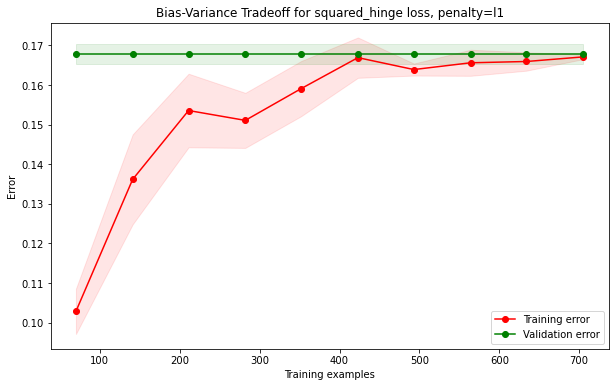

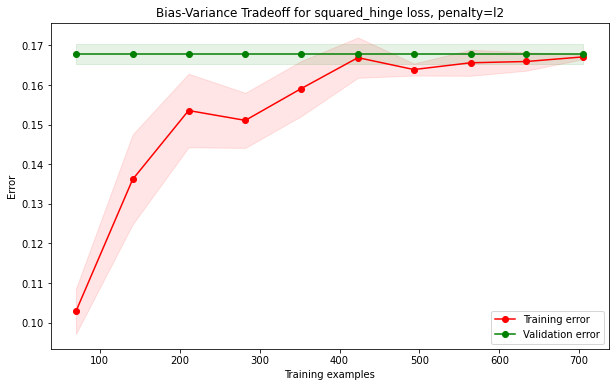

In [37]:
warnings.filterwarnings("ignore")

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.01,0.1, 1,2,4,6,8,10,20,30],
    'loss': ['squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Track C values and corresponding errors
c_values = []
training_errors = []
validation_errors = []

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(x_train, y_train)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, x_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if (params['loss'], params['penalty']) not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add((params['loss'], params['penalty']))

    # Make predictions
    y_pred = svm.predict(x_test)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(x_train, y_train)
        best_val_scores = svm.score(x_val, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(x_train, y_train), svm.score(x_val, y_val)])

    # Store C value and corresponding errors
    c_values.append(params['C'])
    training_errors.append(train_mean[-1])  # Take the last error value for full training set
    validation_errors.append(val_mean[-1])  # Take the last error value for full training set

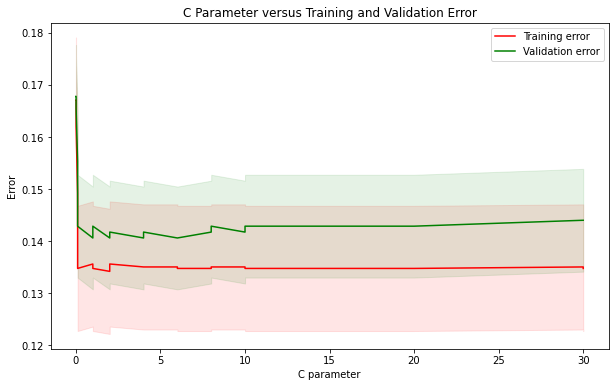

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, training_errors, color='r', label='Training error')
plt.fill_between(c_values, training_errors - np.std(training_errors), training_errors + np.std(training_errors), alpha=0.1, color='r')
plt.plot(c_values, validation_errors, color='g', label='Validation error')
plt.fill_between(c_values, validation_errors - np.std(validation_errors), validation_errors + np.std(validation_errors), alpha=0.1, color='g')
plt.xlabel("C parameter")
plt.ylabel("Error")
plt.title("C Parameter versus Training and Validation Error")
plt.legend(loc="best")
plt.show()

In [39]:
# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))
print("__________________________________")
print()

| Parameters                                             |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|--------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.8322   |    0.829932 |
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.8322   |    0.829932 |
| {'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}  |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0

In [40]:
# Print the best accuracy and corresponding metrics
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_scores)
print("Best Validation Accuracy:", best_val_scores)


Best Accuracy: 0.8945578231292517
Best Parameters: {'C': 20, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best Training Accuracy: 0.8616780045351474
Best Validation Accuracy: 0.8741496598639455


In [41]:
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))


Classification Report for Best Accuracy:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0            |    0.897163 | 0.992157 |   0.942272 | 255        |
| 1            |    0.833333 | 0.25641  |   0.392157 |  39        |
| accuracy     |    0.894558 | 0.894558 |   0.894558 |   0.894558 |
| macro avg    |    0.865248 | 0.624284 |   0.667214 | 294        |
| weighted avg |    0.888696 | 0.894558 |   0.869297 | 294        |


<Figure size 576x432 with 0 Axes>

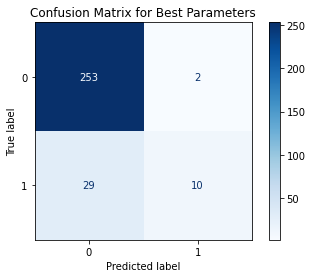

In [42]:
# Create the LinearSVC model with the best parameters
best_svm = LinearSVC(**best_params, dual=False)

# Train the model on the full training set
best_svm.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_svm.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_svm, x_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Best Parameters')
plt.show()

**Trying with x_train_smote , y_train_smote**

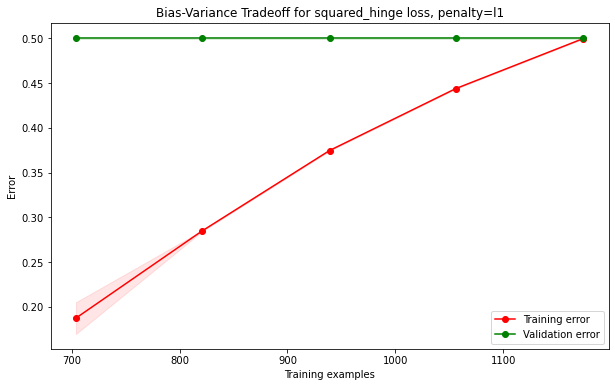

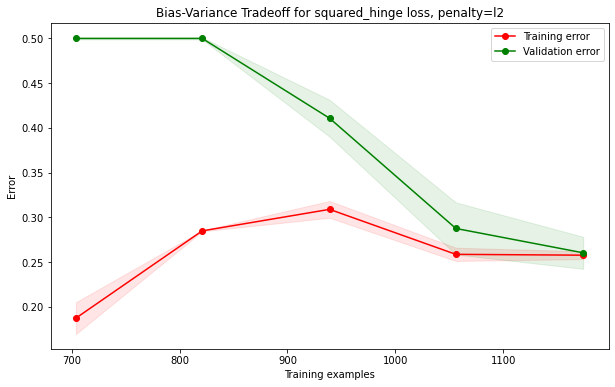

In [43]:
warnings.filterwarnings("ignore")

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.01,0.1, 1,2,4,6,8,10,20,30],
    'loss': ['squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Track C values and corresponding errors
c_values = []
training_errors = []
validation_errors = []

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(x_train_smote, y_train_smote)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, x_train_smote, y_train_smote, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if (params['loss'], params['penalty']) not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add((params['loss'], params['penalty']))

    # Make predictions
    y_pred = svm.predict(x_test)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(x_train_smote, y_train_smote)
        best_val_scores = svm.score(x_val, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(x_train_smote, y_train_smote), svm.score(x_val, y_val)])

    # Store C value and corresponding errors
    c_values.append(params['C'])
    training_errors.append(train_mean[-1])  # Take the last error value for full training set
    validation_errors.append(val_mean[-1])  # Take the last error value for full training set

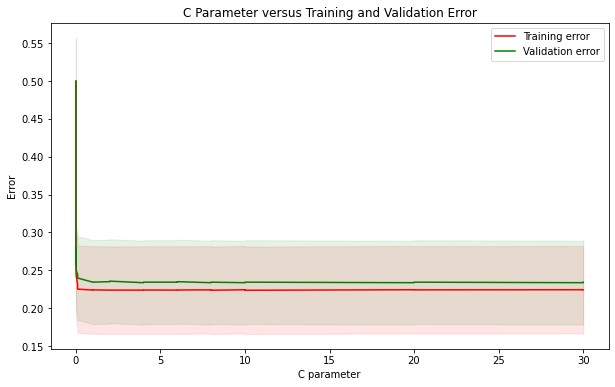

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, training_errors, color='r', label='Training error')
plt.fill_between(c_values, training_errors - np.std(training_errors), training_errors + np.std(training_errors), alpha=0.1, color='r')
plt.plot(c_values, validation_errors, color='g', label='Validation error')
plt.fill_between(c_values, validation_errors - np.std(validation_errors), validation_errors + np.std(validation_errors), alpha=0.1, color='g')
plt.xlabel("C parameter")
plt.ylabel("Error")
plt.title("C Parameter versus Training and Validation Error")
plt.legend(loc="best")
plt.show()

In [45]:
# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))
print("__________________________________")
print()

| Parameters                                             |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|--------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.5      |    0.829932 |
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'} |   0.717687 |    0.841913 | 0.717687 |   0.758997 |       294 |          0.597979 |       0.685219 |         0.596761 |      0.742507 |    0.772109 |
| {'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}  |   0.639456 |    0.822348 | 0.639456 |   0.696853 |       294 |          0.562448 |       0.629261 |         0

In [46]:
# Print the best accuracy and corresponding metrics
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_scores)
print("Best Validation Accuracy:", best_val_scores)


Best Accuracy: 0.8673469387755102
Best Parameters: {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best Training Accuracy: 0.5
Best Validation Accuracy: 0.8299319727891157


In [47]:
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))


Classification Report for Best Accuracy:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0            |    0.867347 | 1        |   0.928962 | 255        |
| 1            |    0        | 0        |   0        |  39        |
| accuracy     |    0.867347 | 0.867347 |   0.867347 |   0.867347 |
| macro avg    |    0.433673 | 0.5      |   0.464481 | 294        |
| weighted avg |    0.752291 | 0.867347 |   0.805732 | 294        |


<Figure size 576x432 with 0 Axes>

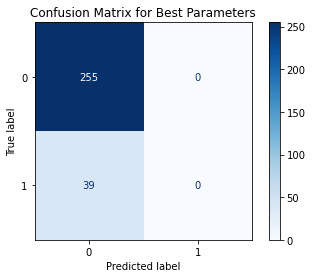

In [48]:
# Create the LinearSVC model with the best parameters
best_svm = LinearSVC(**best_params, dual=False)

# Train the model on the full training set
best_svm.fit(x_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = best_svm.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_svm, x_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Best Parameters')
plt.show()

**Trying with x_train_smotetomek**

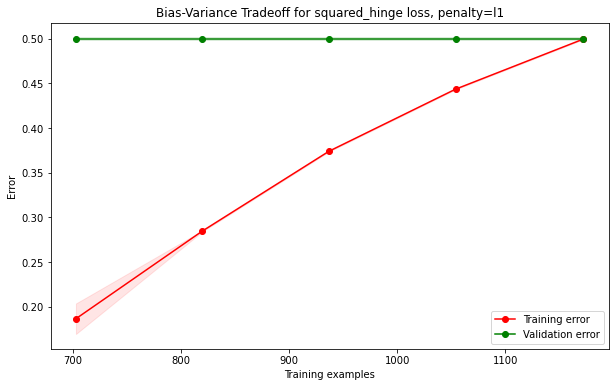

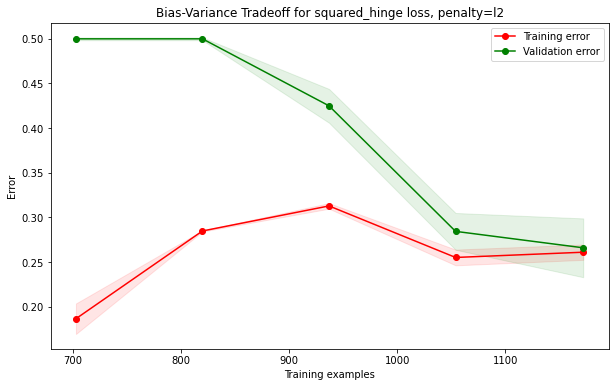

In [49]:
warnings.filterwarnings("ignore")

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.01,0.1, 1,2,4,6,8,10,20,30],
    'loss': ['squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Track C values and corresponding errors
c_values = []
training_errors = []
validation_errors = []

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(x_train_smotetomek, y_train_smotetomek)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, x_train_smotetomek, y_train_smotetomek, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if (params['loss'], params['penalty']) not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add((params['loss'], params['penalty']))

    # Make predictions
    y_pred = svm.predict(x_test)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(x_train_smotetomek, y_train_smotetomek)
        best_val_scores = svm.score(x_val, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(x_train_smotetomek, y_train_smotetomek), svm.score(x_val, y_val)])

    # Store C value and corresponding errors
    c_values.append(params['C'])
    training_errors.append(train_mean[-1])  # Take the last error value for full training set
    validation_errors.append(val_mean[-1])  # Take the last error value for full training set

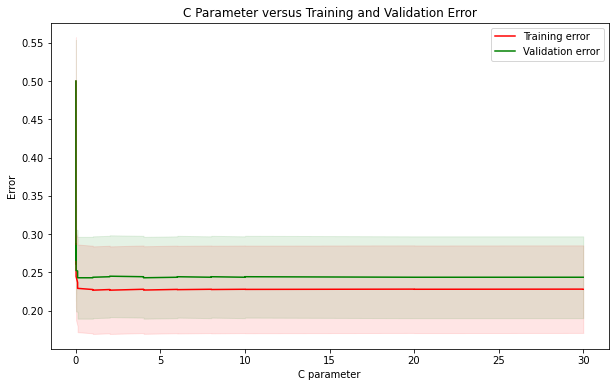

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, training_errors, color='r', label='Training error')
plt.fill_between(c_values, training_errors - np.std(training_errors), training_errors + np.std(training_errors), alpha=0.1, color='r')
plt.plot(c_values, validation_errors, color='g', label='Validation error')
plt.fill_between(c_values, validation_errors - np.std(validation_errors), validation_errors + np.std(validation_errors), alpha=0.1, color='g')
plt.xlabel("C parameter")
plt.ylabel("Error")
plt.title("C Parameter versus Training and Validation Error")
plt.legend(loc="best")
plt.show()

In [51]:
# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))
print("__________________________________")
print()

| Parameters                                             |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|--------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.5      |    0.829932 |
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'} |   0.704082 |    0.834802 | 0.704082 |   0.747936 |       294 |          0.587121 |       0.666516 |         0.581751 |      0.736698 |    0.778912 |
| {'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}  |   0.670068 |    0.832769 | 0.670068 |   0.72169  |       294 |          0.578106 |       0.657768 |         0

In [52]:
# Print the best accuracy and corresponding metrics
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_scores)
print("Best Validation Accuracy:", best_val_scores)


Best Accuracy: 0.8673469387755102
Best Parameters: {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best Training Accuracy: 0.5
Best Validation Accuracy: 0.8299319727891157


In [53]:
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))


Classification Report for Best Accuracy:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0            |    0.867347 | 1        |   0.928962 | 255        |
| 1            |    0        | 0        |   0        |  39        |
| accuracy     |    0.867347 | 0.867347 |   0.867347 |   0.867347 |
| macro avg    |    0.433673 | 0.5      |   0.464481 | 294        |
| weighted avg |    0.752291 | 0.867347 |   0.805732 | 294        |


<Figure size 576x432 with 0 Axes>

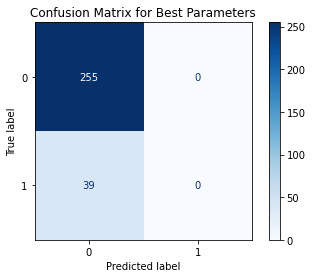

In [54]:
# Create the LinearSVC model with the best parameters
best_svm = LinearSVC(**best_params, dual=False)

# Train the model on the full training set
best_svm.fit(x_train_smotetomek, y_train_smotetomek)

# Make predictions on the test set
y_pred = best_svm.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_svm, x_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Best Parameters')
plt.show()

**Trying with x_train_ros**

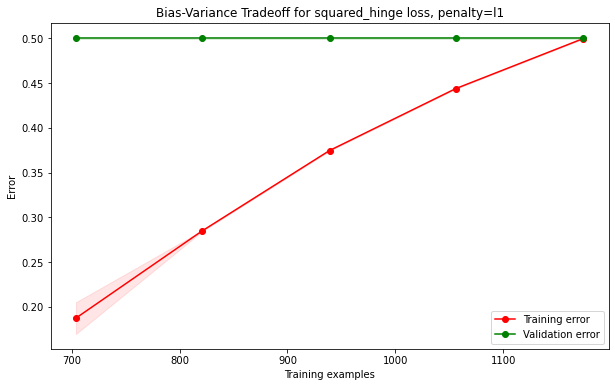

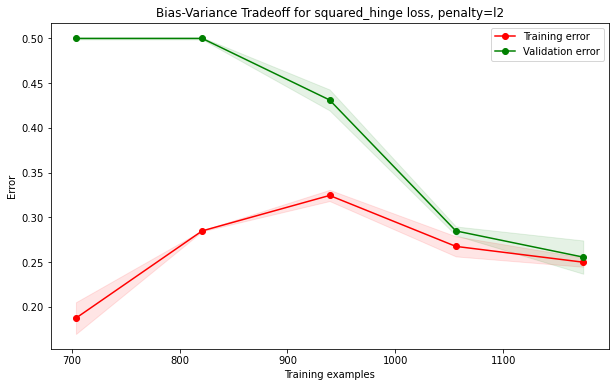

In [55]:
warnings.filterwarnings("ignore")

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.01,0.1, 1,2,4,6,8,10,20,30],
    'loss': ['squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Track C values and corresponding errors
c_values = []
training_errors = []
validation_errors = []

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(x_train_ros, y_train_ros)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, x_train_ros, y_train_ros, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if (params['loss'], params['penalty']) not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add((params['loss'], params['penalty']))

    # Make predictions
    y_pred = svm.predict(x_test)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(x_train_ros, y_train_ros)
        best_val_scores = svm.score(x_val, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(x_train_ros, y_train_ros), svm.score(x_val, y_val)])

    # Store C value and corresponding errors
    c_values.append(params['C'])
    training_errors.append(train_mean[-1])  # Take the last error value for full training set
    validation_errors.append(val_mean[-1])  # Take the last error value for full training set

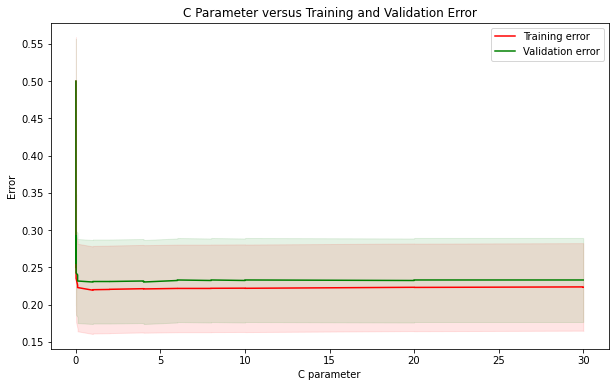

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, training_errors, color='r', label='Training error')
plt.fill_between(c_values, training_errors - np.std(training_errors), training_errors + np.std(training_errors), alpha=0.1, color='r')
plt.plot(c_values, validation_errors, color='g', label='Validation error')
plt.fill_between(c_values, validation_errors - np.std(validation_errors), validation_errors + np.std(validation_errors), alpha=0.1, color='g')
plt.xlabel("C parameter")
plt.ylabel("Error")
plt.title("C Parameter versus Training and Validation Error")
plt.legend(loc="best")
plt.show()

In [57]:
# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))
print("__________________________________")
print()

| Parameters                                             |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|--------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.5      |    0.829932 |
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'} |   0.717687 |    0.83322  | 0.717687 |   0.757809 |       294 |          0.588562 |       0.663499 |         0.587881 |      0.750681 |    0.778912 |
| {'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}  |   0.693878 |    0.823972 | 0.693878 |   0.738964 |       294 |          0.573076 |       0.638914 |         0

In [58]:
# Print the best accuracy and corresponding metrics
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_scores)
print("Best Validation Accuracy:", best_val_scores)


Best Accuracy: 0.8673469387755102
Best Parameters: {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best Training Accuracy: 0.5
Best Validation Accuracy: 0.8299319727891157


In [59]:
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))


Classification Report for Best Accuracy:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0            |    0.867347 | 1        |   0.928962 | 255        |
| 1            |    0        | 0        |   0        |  39        |
| accuracy     |    0.867347 | 0.867347 |   0.867347 |   0.867347 |
| macro avg    |    0.433673 | 0.5      |   0.464481 | 294        |
| weighted avg |    0.752291 | 0.867347 |   0.805732 | 294        |


<Figure size 576x432 with 0 Axes>

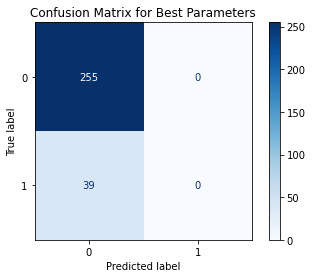

In [60]:
# Create the LinearSVC model with the best parameters
best_svm = LinearSVC(**best_params, dual=False)

# Train the model on the full training set
best_svm.fit(x_train_ros, y_train_ros)

# Make predictions on the test set
y_pred = best_svm.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_svm, x_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Best Parameters')
plt.show()

**Trying x_train_rur**

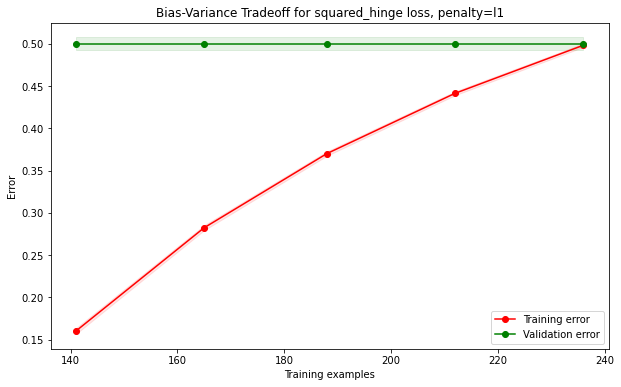

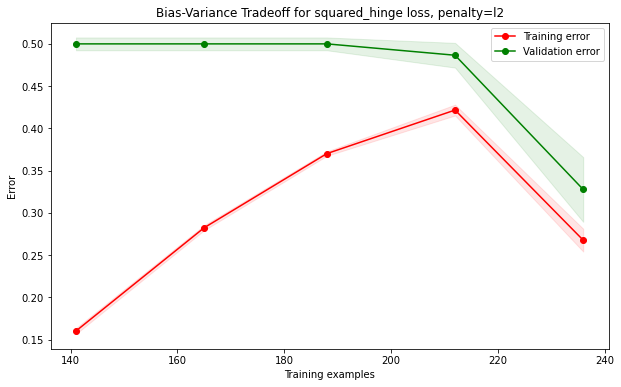

In [61]:
warnings.filterwarnings("ignore")

# Define the parameter grid to search
param_grid = {
    'C': [0.001,0.01,0.1, 1,2,4,6,8,10,20,30],
    'loss': ['squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Track C values and corresponding errors
c_values = []
training_errors = []
validation_errors = []

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(x_train_rur, y_train_rur)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, x_train_rur, y_train_rur, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if (params['loss'], params['penalty']) not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add((params['loss'], params['penalty']))

    # Make predictions
    y_pred = svm.predict(x_test)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(x_train_rur, y_train_rur)
        best_val_scores = svm.score(x_val, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(x_train_rur, y_train_rur), svm.score(x_val, y_val)])

    # Store C value and corresponding errors
    c_values.append(params['C'])
    training_errors.append(train_mean[-1])  # Take the last error value for full training set
    validation_errors.append(val_mean[-1])  # Take the last error value for full training set

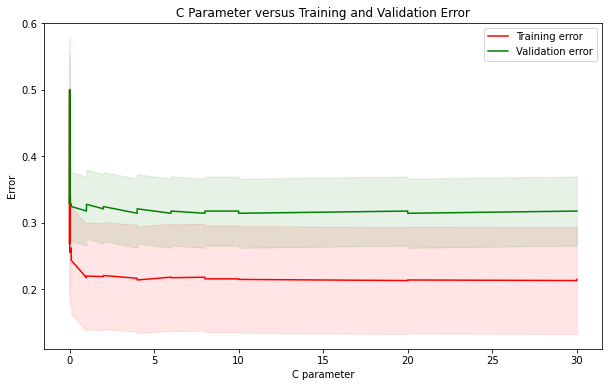

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(c_values, training_errors, color='r', label='Training error')
plt.fill_between(c_values, training_errors - np.std(training_errors), training_errors + np.std(training_errors), alpha=0.1, color='r')
plt.plot(c_values, validation_errors, color='g', label='Validation error')
plt.fill_between(c_values, validation_errors - np.std(validation_errors), validation_errors + np.std(validation_errors), alpha=0.1, color='g')
plt.xlabel("C parameter")
plt.ylabel("Error")
plt.title("C Parameter versus Training and Validation Error")
plt.legend(loc="best")
plt.show()

In [63]:
# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))
print("__________________________________")
print()

| Parameters                                             |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|--------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0.464481 |      0.5      |    0.829932 |
| {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l2'} |   0.70068  |    0.82537  | 0.70068  |   0.744182 |       294 |          0.575991 |       0.642836 |         0.570175 |      0.716216 |    0.761905 |
| {'C': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}  |   0.867347 |    0.752291 | 0.867347 |   0.805732 |       294 |          0.433673 |       0.5      |         0

In [64]:
# Print the best accuracy and corresponding metrics
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_scores)
print("Best Validation Accuracy:", best_val_scores)


Best Accuracy: 0.8673469387755102
Best Parameters: {'C': 0.001, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best Training Accuracy: 0.5
Best Validation Accuracy: 0.8299319727891157


In [65]:
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))


Classification Report for Best Accuracy:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0            |    0.867347 | 1        |   0.928962 | 255        |
| 1            |    0        | 0        |   0        |  39        |
| accuracy     |    0.867347 | 0.867347 |   0.867347 |   0.867347 |
| macro avg    |    0.433673 | 0.5      |   0.464481 | 294        |
| weighted avg |    0.752291 | 0.867347 |   0.805732 | 294        |


<Figure size 576x432 with 0 Axes>

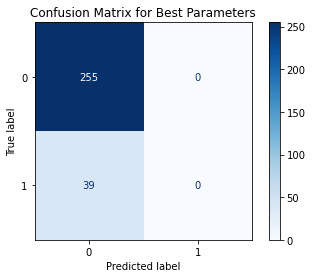

In [66]:
# Create the LinearSVC model with the best parameters
best_svm = LinearSVC(**best_params, dual=False)

# Train the model on the full training set
best_svm.fit(x_train_rur, y_train_rur)

# Make predictions on the test set
y_pred = best_svm.predict(x_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_svm, x_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Best Parameters')
plt.show()